# Projekt 3 - Eksperymenty i analiza danych
## Autorzy
- Daniel Zdancewicz [145317]
- Alex Terentowicz [145419]

## Opis

Projekt polega na przeprowadzeniu eksperymentów z użyciem kilku metod i przeprowadzeniu analizy uzyskanych wyników.
Należało odnaleźć zbiór danych, który zawiera kilka kryteriów monotonicznych, ponad 100 alternatyw i co najmniej 2 klasy (jeśli problem ma więcej klas, możesz je zbinaryzować).

Krótko opisz zbiór danych, w tym opisy kryteriów. Dla tego zbioru danych wytrenuj następujące modele:
- Jeden prosty, interpretowalny model ML (np. XGBoost, rankSVM lub regresja logistyczna)
- Jeden interpretowalny model ANN-MCDA przedstawiony na zajęciach (ANN-Ch-Constr. lub ANN-UTADIS)
- Złożony model sici neuronowej zawierającej kilka warstw ukrytych.


## Opis zbioru danych

W tej pracy wybrany zbiór zawierający dane o udzielonych kredytach. Zbiór zawiera 614 rekordów, 13 kolumn i 2 klasy. Kolumny to:
- Loan_ID — Identyfikator udzielonego kredytu
- Gender — Płeć kredytobiorcy
- Married — Stan cywilny kredytobiorcy
- Dependents — Liczba osób na utrzymaniu kredytobiorcy
- Education — Wykształcenie kredytobiorcy
- Self_Employed — Czy kredytobiorca jest samozatrudniony
- ApplicantIncome — Miesięczny dochód kredytobiorcy
- CoapplicantIncome — Miesięczny dochód współkredytobiorcy
- LoanAmount — Kwota kredytu
- Loan_Amount_Term — Okres spłaty kredytu w miesiącach
- Credit_History — Historia kredytowa kredytobiorcy
- Property_Area — Lokalizacja nieruchomości kredytobiorcy
- Loan_Status — Czy kredyt został spłacony

Źródło danych — [Kaggle](https://www.kaggle.com/altruistdelhite04/loan-prediction-problem-dataset)

Jako kryteria monotoniczne wybrano:
- ApplicantIncome
- CoapplicantIncome
- LoanAmount
- Loan_Amount_Term

Jako kryteria niemonotoniczne wybrano:
- Gender
- Married
- Dependents
- Education
- Self_Employed
- Credit_History
- Property_Area

Jako klasy wybrano kolumnę Loan_Status, która zawiera informacje o tym czy kredyt został spłacony:
- Y — Kredyt został spłacony
- N — Kredyt nie został spłacony



## Preprocessing

Dane zostały wczytane z pliku csv przy użyciu biblioteki pandas. Po czym dokonano na danych zmian polegajacych na usunięciu kolumny Loan_ID, oraz zamianie wartości kolumny Loan_Status na wartości liczbowe:
- Y — 1
- N — 0

Dodatkowo pozostałe kolumny zostały zamienione na wartości liczbowe przy użyciu kodowania liczbowego, aby z łatwością mogły być przetwarzane przez modele ML.

## Naprawa importów

In [22]:
import os
import sys
module_path = os.path.abspath('src')
if module_path not in sys.path: sys.path.append(module_path)

In [23]:
from src.mod.models.manager import ModelManager
from src.mod.dataset import LoanDataset

dataset = LoanDataset.load()
manager = ModelManager

In [24]:
dataset.labeled.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


## Trening modeli

### LogisticRegression — interpretowalny model ML

In [47]:
logistic = ModelManager.use_logistic(dataset, invalidate=True)
print(logistic)

Fitting 10 folds for each of 1 candidates, totalling 10 fits
LogisticModel(regressor=LogisticRegression(), validator=GridSearchCV(cv=10, estimator=LogisticRegression(), n_jobs=-1, param_grid={},
             refit='accuracy',
             scoring={'accuracy': 'accuracy', 'f1': 'f1', 'roc_auc': 'roc_auc'},
             verbose=1))


In [48]:
print(f"Trafność regresji logistycznej ML: {logistic.validator.best_score_*100:.2f}%")

Trafność regresji logistycznej ML: 80.83%


Macierz pomyłek:

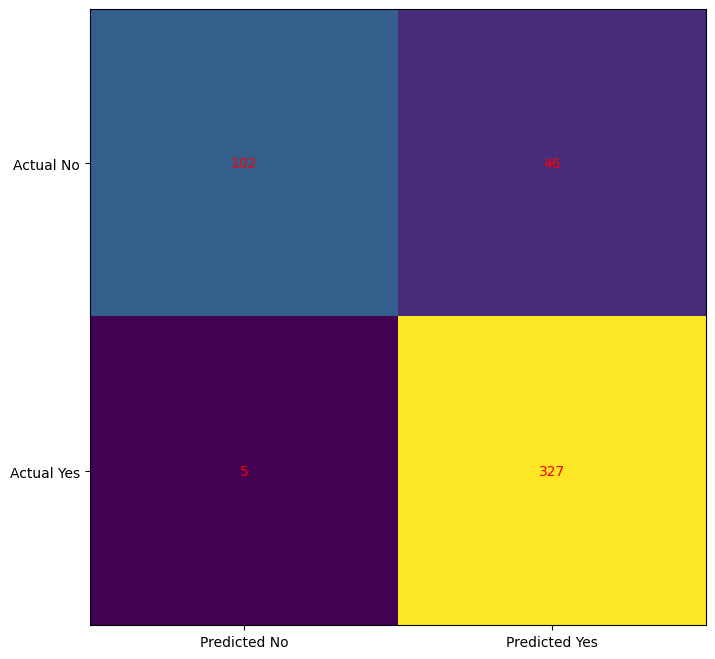

In [59]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix():
    X, y_true, _ = dataset.preprocess(variant='labeled')
    X = logistic._encoder.fit_transform(X)

    y_pred = logistic.validator.predict(X)
    cm = confusion_matrix(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted No', 'Predicted Yes'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual No', 'Actual Yes'))
    ax.set_ylim(1.5, -0.5)
    for i in range(2):
        for j in range(2):
            ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.show()

plot_confusion_matrix()

In [60]:
from sklearn.metrics import classification_report

def print_classification_report():
    X, y_true, _ = dataset.preprocess(variant='labeled')
    X = logistic._encoder.fit_transform(X)

    y_pred = logistic.validator.predict(X)
    print(classification_report(y_true, y_pred))

print_classification_report()

              precision    recall  f1-score   support

           0       0.95      0.69      0.80       148
           1       0.88      0.98      0.93       332

    accuracy                           0.89       480
   macro avg       0.91      0.84      0.86       480
weighted avg       0.90      0.89      0.89       480



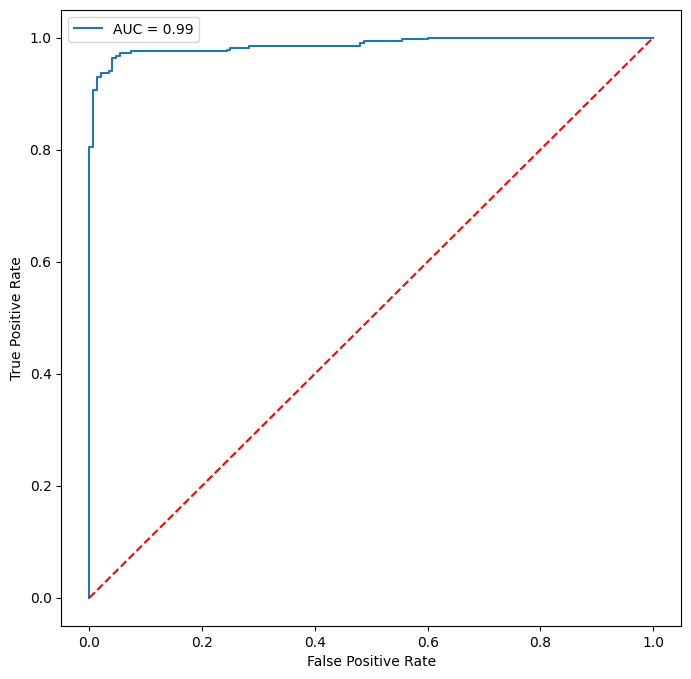

In [61]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve():
    X, y_true, _ = dataset.preprocess(variant='labeled')
    X = logistic._encoder.fit_transform(X)

    y_pred = logistic.validator.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
    ax.plot([0, 1], [0, 1], color='red', linestyle='--')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend()
    plt.show()

plot_roc_curve()

### ANN-Ch-Constr. — interpretowalny model ANN-MCDA

In [ ]:
ann = manager.use_ann(dataset)

### Głęboka sieć neuronowa — model złożony.

Jako model złożony została użyta głęboka sieć neuronowa o architekturze:

Sequential(
  (0): Linear(in_features=11, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): Dropout(p=0.3, inplace=False)
  (6): Linear(in_features=512, out_features=256, bias=True)
  (7): ReLU()
  (8): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): Dropout(p=0.1, inplace=False)
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): ReLU()
  (14): Linear(in_features=128, out_features=64, bias=True)
  (15): ReLU()
  (16): Linear(in_features=64, out_features=32, bias=True)
  (17): ReLU()
  (18): Linear(in_features=32, out_features=1, bias=True)
  (19): Sigmoid()
)


In [ ]:
dnn = manager.use_dnn(dataset)

## Eksperymenty
Wszystkie prezentowane wartości są do maksymalnie 4 miejsc po przecinku.

### Przedstawienie metryk

- Rank SVM
    - Accuracy
    - F1
    - AUC
- ANN-Ch-Constr.
    - Accuracy
    - F1
    - AUC
- Głęboka sieć neuronowa
    - Accuracy
    - F1
    - AUC


### Przedstawienie modelu
(np funkcje cząstkowe, schemat drzewa ...).


### Interpretacja
- Czy na podstawie uzyskanych parametrów możemy powiedzieć coś o preferencjach
użytkowników?
- Czy są jakieś kryteria, które nie mają żadnego wpływu, czy też mają wpływ decydujący.
- Czy istnieją jakieś progi preferencji?
- Czy istnieją oceny kryteriów, które są nierozróżnialne z punktu widzenia preferencji?


### Interpretacja techniką Partial Dependence Plot
Wykonaj interpretację modelu korzystając z conajmniej jednej techniki( Global Surrogate,
Partial Dependence Plot Permutation Feature Importance ...)


Dla 3 wybranych wariantów dokonaj wyjaśnienia decyzji.
- Znajdź minimalną zmianę w ocenach tak aby wariant został przypisany do innej klasy.
    – Spróbuj odpowiedzieć na to pytanie w sposób analityczny, opierając się tylko na
wartościach parametrów modelu i wyjaśnij, dlaczego taka zmiana jest minimalna
(bez próbkowania).
    - Wykonaj próbkowanie przestrzeni, nieznacznie zmieniając oceny, tak aby uzyskać
inną klasę. Czy wyniki zgadzają się z przewidywaniami teoretycznymi?
- Dokonaj wyjaśnienia predykcji za pomocą conajmniej jednej techniki (Anchors LIME,
SHAP, ... )


##### Możliwe narzędzia
Lista narzędzi, które zawierają różne techniki wyjaśniania predykcji i interpretacji modelu:
- Shapash
- Alibi
- Explainerdashboard
- DALEX
- eli5
- aix360#%%
